In [1]:
'''
reference: 
    https://arxiv.org/abs/1508.01211
    https://www.tensorflow.org/tutorials/text/nmt_with_attention
    https://github.com/jameslyons/python_speech_features
    https://www.tensorflow.org/tutorials/customization/custom_layers
    
data source: 
    https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
'''

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import io
import time

In [2]:
import os
import librosa # for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # for audio processing
import warnings
warnings.filterwarnings("ignore")

In [3]:
class WaveReader:
    def __init__(self, path, sample_rate, padding_type, read_size):
        '''
        Args:
            path: train path containing directory which one would like to load
            sample_rate: sample rate for reading .wav file
            padding_type: padding for .wav data length less than 1 second
            read_size: size that one would like to read
        '''
        
        self.path = path
        self.sample_rate = sample_rate
        self.padding_type = padding_type
        self.read_size = read_size

    def read(self, labels=None):
        '''
        read all the data under the labels(directories) one select
        
        Args:
            labels: labels(directories) one would like to load
                    None means read all the directories under that directory
        '''
        print("LABEL\tTOTAL\tREAD\tSAVED\t<1s COUNT")
        print("-----\t-----\t----\t-----\t---------")
        
        if labels is None:
            labels = [f for f in os.listdir(path) if os.path.isdir(path + "\\" + f)]
            
        elif type(labels) == str:
            samples, total_wave_count, total_wave_read, total_loss_count = self.read_dir(dir_name=labels)
            sample_labels = np.repeat(labels, total_wave_read)
            
            print("\n\nMISSION COMPELTE!!!")
            return samples, sample_labels, total_wave_count, total_loss_count
                    
        label_len = len(labels)
        total_wave_count = np.zeros(label_len, dtype=np.int32)
        total_wave_read = np.zeros(label_len, dtype=np.int32)
        total_loss_count = np.zeros(label_len, dtype=np.int32)

        
        for i, lab in enumerate(labels):
            samp, total_wave_count[i], total_wave_read[i], total_loss_count[i] = self.read_dir(dir_name=lab)
            
            if i == 0:
                samples = samp
                sample_labels = np.repeat(lab, total_wave_read[i])
            else:
                samples = np.concatenate((samples, samp), axis=0)
                sample_labels = np.concatenate((sample_labels, np.repeat(lab, total_wave_read[i])), axis=None)
        
        print("\n\nMISSION COMPELTE!!!")
        return samples, sample_labels, total_wave_count, total_loss_count
    
    def read_dir(self, dir_name):
        '''
        read one directory of given directory name
        
        Args:
            dir_name: directory name
        '''
        dir_path = os.path.join(self.path, dir_name)
        wave_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
        total_wave_files = len(wave_files)

        if self.read_size is not None:
            wave_files_read = self.read_size
        else:
            wave_files_read = total_wave_files

        samples = np.zeros((wave_files_read, self.sample_rate))
        less_than_1s_count = 0
        num_of_file_read = 0
        for i, wav_file in enumerate(wave_files):
            wave_file_path = os.path.join(dir_path, wav_file)
            samp, _ = librosa.load(wave_file_path, sr=self.sample_rate)

            pad_size = self.sample_rate - len(samp)
            if pad_size > 0:
                less_than_1s_count += 1
                if self.padding_type is None:
                    # None: than skip this wave file
                    continue

                elif self.padding_type == "white_noise":
                    # white_noise: pad white noise data behind
                    padding = np.random.normal(0, 0.02, pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1


                elif self.padding_type == "zero":
                    # zero: pad zeros behind
                    padding = np.zeros(pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1
            else:
                samples[num_of_file_read, :] = samp
                num_of_file_read += 1

            print("{}\t{}\t{}\t{}\t{}".format(dir_name, 
                                              total_wave_files, 
                                              i+1, 
                                              num_of_file_read, 
                                              less_than_1s_count), end="\r")
            
            if num_of_file_read == wave_files_read:
                break
                
        print()

        return samples, total_wave_files, wave_files_read, less_than_1s_count

In [4]:
SAMPLE_RATE = 16000

train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

reader = WaveReader(path=train_audio_path, 
                    sample_rate=SAMPLE_RATE, 
                    padding_type=None, 
                    read_size=2000)

wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words)

# print("\nCheck the existence of NaN and Inf")
# print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
# print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

LABEL	TOTAL	READ	SAVED	<1s COUNT
-----	-----	----	-----	---------
zero	2376	2160	2000	160
one	2370	2262	2000	262
two	2373	2222	2000	222
three	2356	2207	2000	207
four	2372	2201	2000	201
five	2357	2185	2000	185
six	2369	2164	2000	164
seven	2377	2194	2000	194
eight	2352	2232	2000	232
nine	2364	2178	2000	178


MISSION COMPELTE!!!


In [5]:
class Preprocesser:
    def __init__(self, create_size, min_sz=6, max_sz=8, padding_type="zero"):
        '''
        Args:
            create_size: size of binding wave one would like to create
            min_sz: minimum size of wave data
            max_sz: maximum size of wave data
            padding_type: padding for .wav data length less than 1 second
        '''
        self.create_size = create_size
        self.min_sz = min_sz
        self.max_sz = max_sz
        self.padding_type = padding_type

    def simulate_wave(self, waves):
        '''
        method for simulating wave inputs
        which will concatenate audio inputs for building longer audio dataset
        
        Args:
            waves: input wave data
        '''
        # get picker for combining waves and labels(phonemes)
        self.wave_shape = waves.shape
        self.pickers = self.get_picker()
        
        print("Wave Data Simulation ... ", end="")
        
        binded_length = self.wave_shape[1]*self.max_sz
        simu_wave = np.zeros((self.create_size, binded_length))
        
        
        for i, picker in enumerate(self.pickers):        
            tmp_simu_wave = np.array([waves[p] for p in picker]).flatten()
            
            pad_size = binded_length - len(tmp_simu_wave)
            if pad_size > 0:
                if self.padding_type == "white_noise":
                    # padding white noise
                    padding = np.random.normal(0, 0.02, size=pad_size)

                elif self.padding_type == "zero":
                    # padding zeros
                    padding = np.zeros(pad_size)

                simu_wave[i] = np.concatenate((tmp_simu_wave, padding), axis=None)
                
            else:
                simu_wave[i] = tmp_simu_wave
            
        print("Done")
        return simu_wave
    
    def get_picker(self):
        '''
        picker stands for index pick
        this is for combining audio data with decided minimum and maximum size
        '''
        size = np.random.randint(low=self.min_sz, 
                                 high=self.max_sz+1, 
                                 size=self.create_size)

        picker = np.zeros(self.create_size, dtype=np.object)
        for i, s in enumerate(size):
            picker[i] = np.random.choice(self.wave_shape[0]-1, size=self.max_sz, replace=False)[:s]
            
        return picker

    def simulate_label(self, labels):
        '''
        method for simulating label inputs which will concatenate labels following simulated waves
        
        Args:
            labels: input labels following with audio dataset
        '''
        print("Label Simulation ... ", end="")
        
        simu_label = np.zeros(self.create_size, dtype=np.object)
        for i, picker in enumerate(self.pickers):
            simu_label[i] = np.array([labels[p] for p in picker])
            
        print("Done")
        return simu_label

    def simulate_phoneme(self, labels, label_dict, phoneme_dict):
        '''
        method for sumulating phoneme inputs
        which will concatenate audio phonemes with labels we concated by simulate_label()
        
        Args:
            labels: labels that one would like to transfer
            label_dict: label dictionary
            phoneme_dict: phoneme dictionary
        '''
        print("Phoneme Simulation... ", end="")
        
        self.label_dict = label_dict
        self.phoneme_dict = phoneme_dict

        simu_phoneme = np.empty(self.create_size, dtype=np.object)
        for i, label in enumerate(labels):
            simu_phoneme[i] = " ".join([self.phoneme_translator(lab) for lab in label])
            simu_phoneme[i] = "<start> " + simu_phoneme[i] + " <end>"
            
        print("Done")
        return simu_phoneme

    def phoneme_translator(self, input_label):
        '''
        translate labels to phoneme if simulate_phoneme is called
        
        Args:
            input_label: label that one would like to transfer into phonemes
        '''
        for i, label in enumerate(self.label_dict):
            if input_label == label:
                return self.phoneme_dict[i]
            
    def tokenize(self, phoneme):
        '''
        with tensorflow we can simply apply Tokenizer for text(in our case, phoneme)
        to generate phoneme outputs
        
        Args:
            phoneme: phoneme string with '<start>' and '<end>'
        '''
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
        tokenizer.fit_on_texts(phoneme)
        tensor = tokenizer.texts_to_sequences(phoneme)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, tokenizer

    def show_convert(self, tensor, tokenizer):
        '''
        showing case of tokenized word according to its index
        
        Args:
            tensor: phoneme tensor
            tokenizer: phoneme tokenizer
        '''
        print("\nTOKEN\t--->\tWORDS")
        print("=======================")
        for t in tensor:
            if t != 0:
                print("{}\t--->\t{}".format(t, tokenizer.index_word[t]))

In [6]:
CREATE_SIZE = 2000
MIN_BINDING_SIZE = 1
MAX_BINDING_SIZE = 1

preprocesser = Preprocesser(create_size=CREATE_SIZE, 
                            min_sz=MIN_BINDING_SIZE, 
                            max_sz=MAX_BINDING_SIZE, 
                            padding_type="white_noise")

simu_wave = preprocesser.simulate_wave(wav_array)
simu_label = preprocesser.simulate_label(label_array)
simu_phoneme = preprocesser.simulate_phoneme(labels=simu_label, 
                                             label_dict=phoneme_dataframe.words.values, 
                                             phoneme_dict=phoneme_dataframe.phonemes.values)

print(f"\nExample Label Display: {simu_label[0]}")
print(f"Example Phoneme Display: {simu_phoneme[0]}")

Wave Data Simulation ... Done
Label Simulation ... Done
Phoneme Simulation... Done

Example Label Display: ['seven']
Example Phoneme Display: <start> S EH V AH N <end>


In [7]:
class MFCC:
    '''
    This is the Mel-Frequency Cepstral Coefficients, MFCCs Transformation
    including
        1. Pre-emphasis
        2. Framing
        3. Hamming window
        4. Short-time Fourier Transform
        5. Mel triangular bandpass filters
        6. Log energy
        
    not including
        7. Discrete cosine transform
        8. Delta cepstrum
    '''
    def __init__(self, alpha, frame_size, frame_stride, n_fft, n_filter):
        '''
        Args:
            alpha: coefficient applied when applying pre-emphasis, usually between (0.95, 0.98)
            frame_size: duration of one frame in second
            frame_stride: stride duration of one frame in second
            n_fft: decided number while applying Fast Fourier Transformation
        '''
        self.alpha = alpha
        self.frame_size = frame_size
        self.frame_stride = frame_stride
        self.n_fft = n_fft
        self.n_filter = n_filter
        
    def mfcc(self, samples, sample_rate, apply_delta=False):
        samples_emphasized = self.pre_emphasis(samples)
        frames, total_samples_in_frame = self.framing(samples_emphasized, sample_rate)
        frames = self.hamming_window(frames, total_samples_in_frame)
        power_spectrum = self.stft(frames)
        fbank = self.filter_bank(power_spectrum, sample_rate)
        energy = self.log_energy(fbank)
        mfcc_features = np.column_stack((energy, fbank))
        
        if apply_delta:
            return np.concatenate(mfcc_features, self.delta(mfcc_features))
        else:
            return mfcc_features
    
    def pre_emphasis(self, samples):
        return np.append(samples[0], samples[1:] - self.alpha*samples[:-1])
    
    def framing(self, samples, sample_rate):
        samples_in_frame = int(np.ceil(self.frame_size*sample_rate))                           # number of samples in one frame
        sample_stride = int(np.ceil(self.frame_stride*sample_rate))                            # sample stride in each iteration
        frame_num = int(np.ceil(
            (len(samples) - samples_in_frame)/sample_stride) + 1)                              # number of iterations

        padding_num = (frame_num-1)*sample_stride + samples_in_frame - len(samples)            # length for padding
        padding = np.zeros(padding_num)                                                        # prepare the padding array
        samples_padded = np.append(samples, padding)                                           # padded sample array

        # index to pick all the overlapping samples
        index_each_frame = np.arange(samples_in_frame)
        index_each_stride = np.linspace(0, len(samples_padded) - samples_in_frame, frame_num).astype(np.int32)
        index = np.tile(index_each_frame, reps=(frame_num, 1)) + np.tile(index_each_stride, reps=(samples_in_frame, 1)).T

        return np.array([samples_padded[[i]] for i in index]), samples_in_frame                # frames is a 2D array
    
        
    def hamming_window(self, frames, samples_in_frame):
        # self.frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (self.total_samples_in_one_frame - 1))
        frames *= np.hamming(samples_in_frame)
        return frames
        
    def stft(self, frames):
        magnitude = np.abs(np.fft.rfft(frames, n=self.n_fft))                                  # magnitude of the FFT
        return (1.0/self.n_fft) * magnitude**2                                                 # power spectrum
    
    def filter_bank(self, frames, sample_rate):
        low_freq_mel = 0
        high_freq_mel = self.hz2mel(sample_rate/2)                                             # highest frequency of the Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, self.n_filter+2)                 # Equally spaced in Mel scale
        bins = np.floor((self.n_fft+1) * self.mel2hz(mel_points) / sample_rate)                # bins for FFT
        
        fbank = np.zeros((self.n_filter, self.n_fft//2 + 1))
        for j in range(self.n_filter):
            for i in range(int(bins[j]), int(bins[j+1])):
                fbank[j, i] = (i - bins[j]) / (bins[j+1] - bins[j])
            for i in range(int(bins[j+1]), int(bins[j+2])):
                fbank[j, i] = (bins[j+2] - i) / (bins[j+2] - bins[j+1])
        
        mel_fbanks = np.dot(frames, fbank.T)
        mel_fbanks = np.where(mel_fbanks == 0, np.finfo(float).eps, mel_fbanks)
        mel_fbanks = 20 * np.log10(mel_fbanks)                                                 # dB
        
        return mel_fbanks
        
    def log_energy(self, mel_fbanks):
        return np.log(np.sum(mel_fbanks**2, axis=1))

    def hz2mel(self, hz):
        return 2595 * np.log10(1 + hz/700)  # Convert Hz to Mel
    
    def mel2hz(self, mel):
        return 700 * (10**(mel/2595.0) - 1) # Convert Mel to Hz
    
    def delta(self, mfcc_features, neighbor_len=2):
        denominator = 2 * sum([i**2 for i in np.arange(1, neighbor_len+1)])
        delta_feat = numpy.empty_like(mfcc_features)
        padded = numpy.pad(mfcc_features, ((neighbor_len, neighbor_len), (0, 0)), mode='edge') # padded version of feat
        for t in range(len(mfcc_features)):
            delta_feat[t] = numpy.dot(numpy.arange(-neighbor_len, neighbor_len+1), 
                                      padded[t : t+2*neighbor_len+1]) / denominator # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
        return delta_feat

In [8]:
class MFCCApplier:
    '''
    This is the MFCC applier for applying MFCC 
    and pad zeros for fitting the data into Encoder-Decoder Model with Attention
    which we will build later
    '''
    def __init__(self, alpha, frame_size, frame_stride, n_fft, n_filter):
        '''
        Arg:
            mfcc: build by MFCC class for transform inputs
            decide_size: a 2^k number which will make the inputs reshape into X*decide_size
                         which will help us build the pyramidal RNN encoder
        '''
        self.mfcc = MFCC(alpha=alpha, 
                         frame_size=frame_size, 
                         frame_stride=frame_stride, 
                         n_fft=n_fft, 
                         n_filter=n_filter)
        
    def apply(self, inputs, sample_rate):
        '''
        Args:
            inputs: wave data that one would like to process
        '''
        input_shape = inputs.shape
        
        sample = self.mfcc.mfcc(inputs[0, :], sample_rate)
        sample_shape = sample.shape
        outputs = np.zeros(((input_shape[0], sample_shape[0], sample_shape[1])))
        for i in np.arange(input_shape[0]):
            outputs[i, :, :] = self.mfcc.mfcc(inputs[i, :], sample_rate)
            print(f"Applying MFCC to {i+1}th case", end="\r")
            
        print()
        return outputs

In [9]:
# ALPHA = 0.95
# FRAME_SIZE = 0.025
# FRAME_STRIDE = 0.01
# N_FFT = 512
# N_FILTER = 20

# mfcc_applier = MFCCApplier(alpha=ALPHA, 
#                            frame_size=FRAME_SIZE, 
#                            frame_stride=FRAME_STRIDE, 
#                            n_fft=N_FFT, 
#                            n_filter=N_FILTER)

# mfcced_simu_wave = mfcc_applier.apply(simu_wave, sample_rate=SAMPLE_RATE)
# print("Simulated MFCC wave: (input size, time steps, MFCC dimension) {}".format(mfcced_simu_wave.shape))

In [11]:
import IPython.display as ipd

index = np.random.randint(len(simu_wave), size=1)
print(f"Index: {index}")
print(simu_label[index])
print(simu_phoneme[index])
ipd.Audio(simu_wave[index], rate=SAMPLE_RATE)

Index: [755]
[array(['nine'], dtype='<U4')]
['<start> N AY N <end>']


In [12]:
from python_speech_features import logfbank

ex_shape = logfbank(simu_wave[0], SAMPLE_RATE).shape
mfcced_simu_wave = np.zeros(((len(simu_wave), ex_shape[0], ex_shape[1])))
for i, wave in enumerate(simu_wave):
    mfcc = logfbank(wave, SAMPLE_RATE)
    
#     mean = np.mean(mfcc, axis=0)
#     std = np.std(mfcc, axis=0)
#     mfcced_simu_wave[i, :, :] = (mfcc - mean) / std
    mfcced_simu_wave[i, :, :] = mfcc
    
    print(f"Transfering {i+1}th case", end="\r")

print()

Transfering 2000th case


In [13]:
phoneme_tensor, phoneme_tokenizer = preprocesser.tokenize(simu_phoneme)

print("Input Shape: {}".format(mfcced_simu_wave.shape))
print("Output Shape: {}".format(phoneme_tensor.shape))


for tensor in phoneme_tensor[:1]:
    preprocesser.show_convert(tensor, phoneme_tokenizer)
    print()
    
# Split the data into size (training set, testing set) (18000, 2000)
TRAIN_SIZE = 0.9

wav_tensor, wav_tensor_val, phoneme_tensor, phoneme_tensor_val = train_test_split(mfcced_simu_wave, 
                                                                                  phoneme_tensor, 
                                                                                  train_size=TRAIN_SIZE, 
                                                                                  random_state=None, 
                                                                                  shuffle=True)

Input Shape: (2000, 99, 26)
Output Shape: (2000, 7)

TOKEN	--->	WORDS
1	--->	<start>
5	--->	s
18	--->	eh
11	--->	v
9	--->	ah
3	--->	n
2	--->	<end>



In [14]:
BATCH_SIZE = 4
LSTM_UNITS = 256
EMBEDDING_DIM = 128
WAV_SIZE = len(wav_tensor)
VAL_WAV_SIZE = len(wav_tensor_val)
PHONEME_SIZE = len(phoneme_tokenizer.word_index) + 1
STEP_PER_EPOCH = WAV_SIZE // BATCH_SIZE

wav_tensor = tf.convert_to_tensor(wav_tensor, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((wav_tensor, phoneme_tensor)).shuffle(WAV_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
print(f"Example Input Shape: {example_input_batch.shape}")
print(f"Example Output Shape: {example_target_batch.shape}")

Example Input Shape: (4, 99, 26)
Example Output Shape: (4, 7)


In [16]:
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters, stride=None):
        super(ResnetIdentityBlock, self).__init__()
        self.filters1, self.filters2, self.filters3 = filters
        
        if stride is None:
            self.stride = 1
        else:
            self.stride = stride

        self.conv1 = tf.keras.layers.Conv1D(self.filters1, self.stride, padding='valid', activation="relu")
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv1D(self.filters2, kernel_size, padding='same', activation="relu")
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv1D(self.filters3, 1, padding='valid', activation="relu")
        self.bn3 = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.stride != 1:
            short_cut = tf.keras.layers.Conv1D(self.filters3, 
                                               self.stride, 
                                               padding='valid', 
                                               activation="relu")(input_tensor)
            x += short_cut
        else:
            x += input_tensor
        return tf.nn.relu(x)

In [17]:
resnet_block = ResnetIdentityBlock(32, [1, 2, example_input_batch.shape[-1]])
resnet_output = resnet_block(example_input_batch)

print("Attention result shape: (batch size, units) {}".format(resnet_output.shape))

Attention result shape: (batch size, units) (4, 99, 26)


In [18]:
resnet_block.summary()

Model: "resnet_identity_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  27        
_________________________________________________________________
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  66        
_________________________________________________________________
batch_normalization_1 (Batch multiple                  8         
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  78        
_________________________________________________________________
batch_normalization_2 (Batch multiple                  104       
Total params: 287
Trainable params: 229
Non-trainable params: 58
______________________________________________

In [48]:
class Encoder(tf.keras.Model):
    '''
    Encoder for MFCC transformed wave data
    '''
    def __init__(self, 
                 lstm_units, 
                 batch_sz, 
                 dropout_rate, 
                 squeeze_time, 
                 rnn_initial_weight=None):
        '''
        Args:
            lstm_units: LSTM units number
            batch_sz: batch size            
            dropout_rate: layer dropout ratio
            rnn_initial_weight: type of weight initialization
        '''
        super(Encoder, self).__init__()
        self.lstm_units = lstm_units    
        self.squeeze_time = squeeze_time
        self.rnn_initial_weight = rnn_initial_weight
        
        # normalization
        self.bn = tf.keras.layers.BatchNormalization()
        
        # conv1d
        conv_units = 64
        self.conv = tf.keras.layers.Conv1D(filters=conv_units, 
                                           kernel_size=5, 
                                           strides=1, 
                                           padding='same', 
                                           activation="relu", 
                                           kernel_initializer='glorot_uniform')
        
        # ResNet
#         self.resnet1 = ResnetIdentityBlock(32, filters=[conv_units//4, conv_units//2, conv_units])
#         self.resnet2 = ResnetIdentityBlock(64, [conv_units//4, conv_units//2, conv_units])
#         self.resnet3 = ResnetIdentityBlock(128, [conv_units//4, conv_units//2, conv_units])
        
        # pBLSTM1
        self.fw_lstm1 = tf.keras.layers.LSTM(units=lstm_units, 
                                             return_sequences=True, 
                                             return_state=True, 
                                             kernel_initializer="lecun_normal",
                                             activation='tanh', 
                                             recurrent_activation='sigmoid', 
                                             recurrent_initializer='orthogonal', 
                                             dropout=dropout_rate)
        
        self.bw_lstm1 = tf.keras.layers.LSTM(units=lstm_units, 
                                             return_sequences=True, 
                                             return_state=True, 
                                             kernel_initializer="lecun_normal",
                                             activation='tanh', 
                                             recurrent_activation='sigmoid', 
                                             recurrent_initializer='orthogonal', 
                                             dropout=dropout_rate, 
                                             go_backwards=True)
        self.bn_pblstm1 = tf.keras.layers.BatchNormalization()
        
        # pBLSTM2
#         self.fw_lstm2 = tf.keras.layers.LSTM(units=lstm_units, 
#                                              return_sequences=True, 
#                                              return_state=True, 
#                                              kernel_initializer="lecun_normal",
#                                              activation='tanh', 
#                                              recurrent_activation='sigmoid', 
#                                              recurrent_initializer='orthogonal', 
#                                              dropout=dropout_rate)
        
#         self.bw_lstm2 = tf.keras.layers.LSTM(units=lstm_units, 
#                                              return_sequences=True, 
#                                              return_state=True, 
#                                              kernel_initializer="lecun_normal",
#                                              activation='tanh', 
#                                              recurrent_activation='sigmoid', 
#                                              recurrent_initializer='orthogonal', 
#                                              dropout=dropout_rate, 
#                                              go_backwards=True)
#         self.bn_pblstm2 = tf.keras.layers.BatchNormalization()
        
        # Encoder lstm
        self.enc_lstm = tf.keras.layers.LSTM(units=lstm_units, 
                                             return_sequences=True, 
                                             return_state=True, 
                                             kernel_initializer="lecun_normal",
                                             activation='tanh', 
                                             recurrent_activation='sigmoid', 
                                             recurrent_initializer='orthogonal', 
                                             dropout=dropout_rate)
        
        # build layer info dictionary
        self.layer_info = dict()
        
    def call(self, inputs):
        '''
        call pyramidal LSTM neural network encoder
        
        Args:
            inputs: wave input
        '''
        self.layer_info["Input"] = inputs.shape
        x = self.bn(inputs)
        x = self.conv(x)
        
        # ResNet
#         x = self.resnet1(x)
#         x = self.resnet2(x)
#         x = self.resnet3(x)
        
        # pBLSTM 1
        fw_outputs, fw_state_h, fw_state_c = self.fw_lstm1(x)
        bw_outputs, bw_state_h, bw_state_c = self.bw_lstm1(x)
        x = tf.concat([fw_outputs, bw_outputs], axis=-1)
        x = self.reshape_pyramidal(x)
        x = self.bn_pblstm1(x)
        
        # pBLSTM 2
#         fw_outputs, fw_state_h, fw_state_c = self.fw_lstm2(x)
#         bw_outputs, bw_state_h, bw_state_c = self.bw_lstm2(x)
#         x = tf.concat([fw_outputs, bw_outputs], axis=-1)
#         x = self.reshape_pyramidal(x)
#         x = self.bn_pblstm2(x)
        
        # encoder output layer
        fw_outputs, fw_state_h, fw_state_c = self.enc_lstm(x)
            
        return fw_outputs, fw_state_h, fw_state_c
    
    def reshape_pyramidal(self, outputs):
        '''
        After concatenating forward and backward outputs
        return the reshaped output
        
        Args:
            outputs: outputs from LSTM
            squeeze_time: time step one would like to squeeze in pyramidal LSTM
        '''
        batch_size, time_steps, num_units = outputs.shape

        return tf.reshape(outputs, (batch_size, -1, num_units * self.squeeze_time))    

In [49]:
ENCODER_DROPOUT_RATE = 0.0
encoder = Encoder(lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=ENCODER_DROPOUT_RATE, 
                  rnn_initial_weight="normal", 
                  squeeze_time=3)

# If set the batch size greater than 4, memory of GPU will run out
sample_output, fw_sample_state_h, fw_sample_state_c = encoder(example_input_batch)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder forward state h shape: (batch size, units) {}'.format(fw_sample_state_h.shape))

Encoder output shape: (batch size, sequence length, units) (4, 33, 256)
Encoder forward state h shape: (batch size, units) (4, 256)


In [50]:
encoder.summary()

Model: "encoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_57 (Batc multiple                  104       
_________________________________________________________________
conv1d_52 (Conv1D)           multiple                  8384      
_________________________________________________________________
lstm_18 (LSTM)               multiple                  328704    
_________________________________________________________________
lstm_19 (LSTM)               multiple                  328704    
_________________________________________________________________
batch_normalization_58 (Batc multiple                  6144      
_________________________________________________________________
lstm_20 (LSTM)               multiple                  1836032   
Total params: 2,508,072
Trainable params: 2,504,948
Non-trainable params: 3,124
___________________________________________

In [51]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, activation="relu")
        self.W2 = tf.keras.layers.Dense(units, activation="relu")
        self.V = tf.keras.layers.Dense(1, activation="relu")

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(fw_sample_state_h, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (4, 256)
Attention weights shape: (batch_size, sequence_length, 1) (4, 33, 1)


In [53]:
class Decoder(tf.keras.Model):
    '''
    Decoder for output phonemes
    '''
    def __init__(self, 
                 target_sz, 
                 embedding_dim, 
                 lstm_units, 
                 batch_sz, 
                 dropout_rate):
        '''
        Args:
            target_sz: target size, total phoneme size in this case
            embedding_dim: embedding dimension
            lstm_units: LSTM units number
            batch_sz: batch size
            dropout_rate: dropout ratio
            rnn_initial_weight: type of weight initialization
        '''
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.target_sz = target_sz
        self.lstm_units = lstm_units
        self.embedding = tf.keras.layers.Embedding(target_sz, embedding_dim)
        
        # attention model
        self.attention = LuongAttention(lstm_units)
        
        # decoder rnn            
        self.lstm1 = tf.keras.layers.LSTM(units=lstm_units, 
                                          return_sequences=True, 
                                          return_state=True, 
                                          kernel_initializer="lecun_normal",
                                          activation='tanh',
                                          recurrent_activation='sigmoid', 
                                          recurrent_initializer='orthogonal', 
                                          dropout=dropout_rate)
        
        self.lstm2 = tf.keras.layers.LSTM(units=lstm_units, 
                                          return_sequences=True, 
                                          return_state=True, 
                                          kernel_initializer="lecun_normal",
                                          activation='tanh',
                                          recurrent_activation='sigmoid', 
                                          recurrent_initializer='orthogonal', 
                                          dropout=dropout_rate)

        # ResNet
        self.resnet1 = ResnetIdentityBlock(32, [lstm_units//4, lstm_units//2, lstm_units])
        self.resnet1_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.resnet2 = ResnetIdentityBlock(64, [lstm_units//4, lstm_units//2, lstm_units])
        self.resnet2_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.resnet3 = ResnetIdentityBlock(128, [lstm_units//4, lstm_units//2, lstm_units])
        self.resnet3_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        

#         self.conv1 = tf.keras.layers.Conv1D(64, 13, padding="same", activation="relu")
#         self.conv2 = tf.keras.layers.Conv1D(128, 11, padding="same", activation="relu")
#         self.conv3 = tf.keras.layers.Conv1D(256, 9, padding="same", activation="relu")
    
        # Fully-connected
        self.fc1 = tf.keras.layers.Dense(64, activation="relu")
        self.fc1_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.fc2 = tf.keras.layers.Dense(target_sz, activation="softmax")
        
        # build layer info dictionary
        self.layer_info = dict()


    def call(self, inputs, enc_hidden_h, enc_hidden_c, enc_output):
        '''
        call LSTM decoder
        
        Args:
            inputs: target output, following phoneme for wave data input in this case
            enc_hidden_h: encoder hidden state h
            enc_hidden_c: encoder hidden state c
            enc_output: encoder outputs
        '''
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(inputs)

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(enc_hidden_h, enc_output)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the 2-layer LSTM (Decoder)
        outputs, state_h, state_c = self.lstm1(x)
        outputs, state_h, state_c = self.lstm2(outputs)

        # ResNet
        x = self.resnet1(outputs)
        x = self.resnet1_dropout(x)
        
        x = self.resnet2(x)
        x = self.resnet2_dropout(x)
        
        x = self.resnet3(x)
        x = self.resnet3_dropout(x)

        # Convolution
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
    
        # dense layer before final predict output dense layer
        x = tf.reshape(x, (-1, x.shape[-1]))
        x = self.fc1(x)
        x = self.fc1_dropout(x)
        
        # output shape == (batch_size, phoneme size)
        x = self.fc2(x)

        return x, (state_h, state_c), attention_weights

In [54]:
DECODER_DROPOUT_RATE = 0.0
decoder = Decoder(target_sz=PHONEME_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=DECODER_DROPOUT_RATE)

sample_target_size = tf.random.uniform((BATCH_SIZE, 1))
sample_decoder_output, sample_decoder_hidden, attention_weights = decoder(
    inputs=sample_target_size, 
    enc_hidden_h=fw_sample_state_h, 
    enc_hidden_c=fw_sample_state_c, 
    enc_output=sample_output)

print ('Decoder output shape: (batch_size, phoneme size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, phoneme size) (4, 22)


In [55]:
decoder.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  2816      
_________________________________________________________________
luong_attention_4 (LuongAtte multiple                  131841    
_________________________________________________________________
lstm_21 (LSTM)               multiple                  656384    
_________________________________________________________________
lstm_22 (LSTM)               multiple                  525312    
_________________________________________________________________
resnet_identity_block_16 (Re multiple                  313536    
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
resnet_identity_block_17 (Re multiple                  57

In [71]:
# adjust learning rate
LEARNING_RATE = 0.00001

'''
Candidate optimizer:
    1. Adam
    2. Nadam
    
    the preformence of other optimizers are not good
'''

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=LEARNING_RATE)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [67]:
encoder = Encoder(lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=ENCODER_DROPOUT_RATE, 
                  rnn_initial_weight="normal", 
                  squeeze_time=3)

decoder = Decoder(target_sz=PHONEME_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=DECODER_DROPOUT_RATE)

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [69]:
@tf.function
def train_step(inp, targ, targ_tokenizer):
    loss = 0
    
    with tf.GradientTape() as tape:
        # forward algorithm
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
        dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
        dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, (dec_hidden_h, dec_hidden_c), _ = decoder(dec_input, dec_hidden_h, dec_hidden_c, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    # backward algorithm
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5)  # clipping for avoiding gradient explosion
    optimizer.apply_gradients(zip(clipped_gradients, variables))

#     translate(test_wave, sample_output.shape[1], sample_decoder_output.shape[1], phoneme_tokenizer)
    return batch_loss

In [74]:
# run eagerly will make tensorflow run step by step or else it will raise
# ValueError: tf.function-decorated function tried to create variables on non-first call.
# similar to Pytorch, which is a dynamic graph for deep learning
tf.config.experimental_run_functions_eagerly(True)

EPOCHS = 100
start = time.time()
for epoch in range(1, EPOCHS+1):
    epoch_start = time.time()
    
    print("{:>5}  {:>5}  {:>8}  {:>10}".format("Epoch", " Batch", "Loss ", "  Time(s)"))
    
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(STEP_PER_EPOCH)):
        batch_loss = train_step(inp, targ, phoneme_tokenizer)
        
        total_loss += batch_loss
            
        if batch % 100 == 0:
            print('{:<5}  {:>5}  {:>8}  {:>10}'.format("{}/{}".format(epoch, EPOCHS), 
                                                       batch, 
                                                       "{:.4f}".format(batch_loss.numpy()), 
                                                       "{:.4f}".format(time.time() - epoch_start)))

    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix=checkpoint_prefix)

    print("\n================================")
    print('Epoch {} Loss {:.4f}'.format(epoch, total_loss / STEP_PER_EPOCH))
    print('Time taken for epoch {} -- {:.4f} min'.format(epoch, 
                                                         (time.time() - epoch_start)/60))
    print('Total Time taken -- {:.4f} min'.format((time.time() - start)/60))
    print("================================\n")

Epoch  Batch     Loss      Time(s)
1/100      0    1.4178      0.4410
1/100    100    1.5079     42.0200
1/100    200    1.5246     87.5831
1/100    300    1.5250    130.6851
1/100    400    1.5445    172.5231

Epoch 1 Loss 1.6307
Time taken for epoch 1 -- 3.2359 min
Total Time taken -- 3.2359 min

Epoch  Batch     Loss      Time(s)
2/100      0    1.6472      0.4260
2/100    100    1.4120     39.6440
2/100    200    1.5608     79.5824
2/100    300    1.3746    118.7664
2/100    400    1.5784    158.9347

Epoch 2 Loss 1.6284
Time taken for epoch 2 -- 2.9902 min
Total Time taken -- 6.2261 min

Epoch  Batch     Loss      Time(s)
3/100      0    1.3333      0.3970
3/100    100    1.4480     39.2590
3/100    200    1.2893     81.4795
3/100    300    1.6457    121.5725
3/100    400    1.4895    162.5238

Epoch 3 Loss 1.6258
Time taken for epoch 3 -- 3.0782 min
Total Time taken -- 9.3043 min

Epoch  Batch     Loss      Time(s)
4/100      0    1.6368      0.3990
4/100    100    1.9757     41.

KeyboardInterrupt: 

In [61]:
def predict(inputs, max_input_len, max_output_len, tokenizer=None):
    attention_plot = np.zeros((max_output_len, max_input_len))
    
    inputs = tf.expand_dims(inputs, 0)
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs)
    
    dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in np.arange(max_output_len):
        predictions, dec_hidden, attention_weights = decoder(
            inputs=dec_input, 
            enc_hidden_h=dec_hidden_h, 
            enc_hidden_c=dec_input, 
            enc_output=enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += tokenizer.index_word[predicted_id] + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [62]:
# function for plotting the attention weights
def plot_attention(attention, input_wav, output_phoneme):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # ax.set_xticklabels([''] + input_wav, fontdict=fontdict, rotation=90)
#     ax.set_xticklabels(range(len(input_wav)))
    ax.set_yticklabels([''] + output_phoneme, fontdict=fontdict)

    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [63]:
def translate(wave, max_in, max_out, tokenizer):
    result, attention_plot = predict(wave, max_in, max_out, tokenizer)

    print(f'Original Input Length: {len(wave)}')
    print(f'Predicted translation: {result}')

    attention_plot = attention_plot[:len(result.split(' ')), :50]
    plot_attention(attention_plot, np.arange(len(wave)), result.split(' '))

In [72]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Index: [25]
Original Input Length: 99
Predicted translation: f s f s f s f s f s f s f s f s f s f s f s 


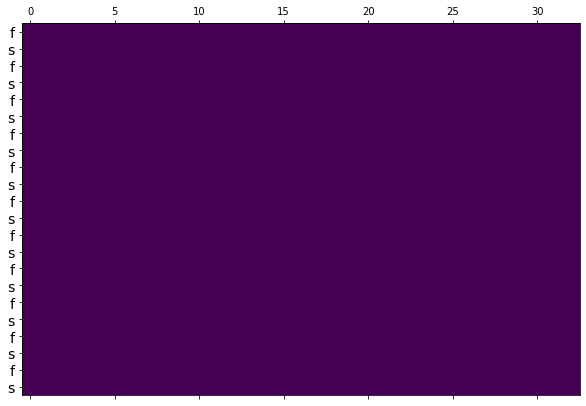


TOKEN	--->	WORDS
1	--->	<start>
3	--->	n
6	--->	ay
3	--->	n
2	--->	<end>


In [65]:
# testing with test wave data
index = np.random.randint(len(wav_tensor_val), size=1)
print(f"Index: {index}")
test_wave = tf.convert_to_tensor(wav_tensor_val[0], dtype=tf.float32)
translate(test_wave, sample_output.shape[1], sample_decoder_output.shape[1], phoneme_tokenizer)

test_phoneme = phoneme_tensor_val[0]
preprocesser.show_convert(test_phoneme, phoneme_tokenizer)